<a href="https://colab.research.google.com/github/pedrohortencio/text-generator/blob/main/Poetry_Generator_Machado_de_Assis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import regex as re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!kaggle datasets download -d luxedo/machado-de-assis

!unzip /content/machado-de-assis.zip

In [ ]:
data = open('/content/raw/txt/poesia/ocidentais.txt').read()
corpus1 = data.lower().split("\n")
corpus1 = corpus1[28:]    # Sem o índice

data = open('/content/raw/txt/poesia/crisalidas.txt').read()
corpus2 = data.lower().split("\n")
corpus2 = corpus2[34:2089]

data = open('/content/raw/txt/poesia/almada.txt').read()
corpus3 = data.lower().split("\n")
corpus3 = corpus3[100:2518]

data = open('/content/raw/txt/poesia/gazeta.txt').read()
corpus4 = data.lower().split("\n")
corpus4 = corpus4[4:4455]


corpus = corpus1 + corpus2 + corpus3 + corpus4

In [ ]:
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

to_exclude = '"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '!?'

corpus = [text.replace("-", "") for text in corpus]

corpus = [re.sub(r'(['+to_tokenize+'])', r' \1 ', i) for i in corpus]

tokenizer = Tokenizer(filters=to_exclude)
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

print(len(tokenizer.word_index))

10922


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(256, return_sequences = True)))
#model.add(LSTM(200, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(LSTM(256, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128))

#model.add(Dense(total_words/6, activation='relu'))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(predictors, label, batch_size=256,epochs=200) 

Epoch 1/200
174/174 [==============================] - 6s 35ms/step - loss: 7.3421 - accuracy: 0.0353
Epoch 2/200
174/174 [==============================] - 6s 34ms/step - loss: 7.3338 - accuracy: 0.0357
Epoch 3/200
174/174 [==============================] - 6s 34ms/step - loss: 7.3303 - accuracy: 0.0349
Epoch 4/200
174/174 [==============================] - 6s 34ms/step - loss: 7.2804 - accuracy: 0.0347
Epoch 5/200
174/174 [==============================] - 6s 34ms/step - loss: 7.1622 - accuracy: 0.0407
Epoch 6/200
174/174 [==============================] - 6s 34ms/step - loss: 7.0101 - accuracy: 0.0469
Epoch 7/200
174/174 [==============================] - 6s 34ms/step - loss: 6.8880 - accuracy: 0.0504
Epoch 8/200
174/174 [==============================] - 6s 34ms/step - loss: 6.7849 - accuracy: 0.0529
Epoch 9/200
174/174 [==============================] - 6s 35ms/step - loss: 6.6897 - accuracy: 0.0599
Epoch 10/200
174/174 [==============================] - 6s 35ms/step - loss: 6.594

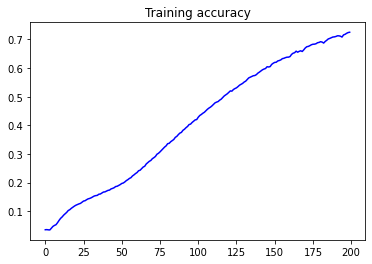

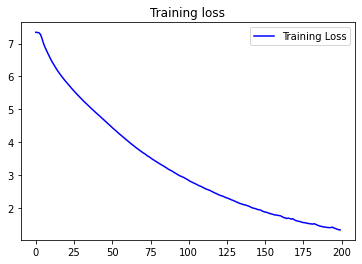

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
!zip -r /content/model-poetry-generator-ptbrV1.01.06041716.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 90%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 68%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
model.save_weights('poetry-generator-ptbrV1.01.06041716.h5')

In [ ]:
#seed_text = "Minha alma"
#seed_text = 'Nenhuma quantidade de liberdade'
#seed_text = 'Água mole em pedra dura'
seed_text = 'Os olhos dela brilhavam como o sol'

next_words = 40
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    #predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

seed_text = seed_text.replace(" .", ".").replace(" ,", ",").replace(" !", "!").replace(" ?", "?").replace(" :", ":")

print(seed_text)

Os olhos dela brilhavam como o sol dos pássaros feios e bela o cardoso mas quero?? as suas lindas novelas dos séculos rompendo e quero o pernas que que mil que blasfêmias e raios dos dedos o filho vivaz da horas minhas vivos versos ver
